# Shallow focus를 이용한 인물사진 만들기

### DeepLab segmentation model 적용

1.배경이 있는 셀카를 촬영 (배경과 사람의 거리가 약간 멀리 있는게 좋음)

2.시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리

3.블러링(blurring) 기술로 배경을 흐리게 함

4.피사체를 배경의 원래 위치에 합성

## 루브릭

- 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.


- 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.


- 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

## 용어 정리

- urllib는 웹에서 데이터를 다운로드할 때 사용함.

- cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요함.

- pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리

- segmentAsPascalvoc :  PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미

- blur() : 배경을 흐리게하는 함수

- bitwise_not : 이미지가 반전(원본 마스크에서 배경이 0, 사람이 255였다면, 이 함수 사용시 배경이 255, 사람이 0 이됨)

- bitwise_and : 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있음. ( 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨, 즉 사람이 사라짐)

- numpy.where(condition, [x, y, ]/)

### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법

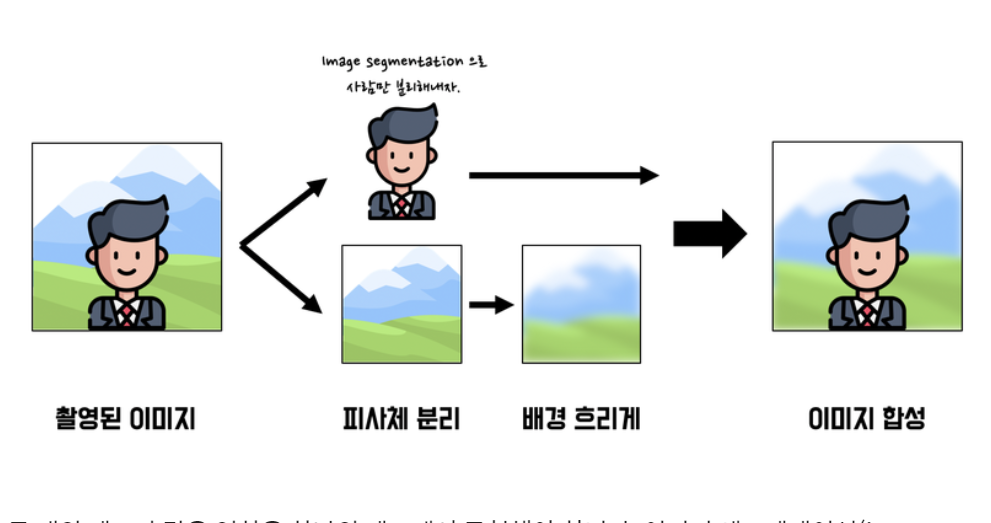

## 라이브러리 import

In [1]:
import os
from glob import glob
from os.path import join
import tarfile
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
import tensorflow as tf

## 이미지 준비하기

## 1. 인물사진

(1440, 1440, 3)


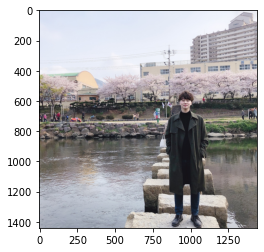

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/oh.png'  
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션으로 사람 분리하기

- Segmentation : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
- DeepLab V3+ : semantic segmentation 방법으로서,separable convolution과 atrous convolution을 결합한 atrous separable convolution의 활용을 제안하고 있음
- atrous convolution을 사용한 이유 : receptive field를 넓게 사용하기 위해 사용하며, 적은 파라미터로 필터가 더 넓은 영역을 보게 할 수 있음.
- Depthwise separable convolution : 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적

In [3]:
# 저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0de76dcd60>)

## Semantic segmentation

- Semantic segmentation : 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류하고(classification)하는 방법으로서 개개별로 라벨링하는 것이 아닌 분류된 형태로서 라벨링 됨. ex) 영희와 숙희가 사람으로 라벨링 되는 것


In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)
#PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요

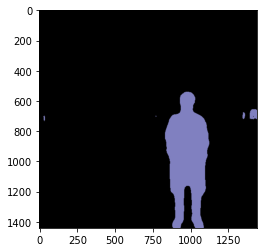

In [6]:
# person 라벨, 즉 15를 가진 영역만 검출해 내고 싶을 때
plt.imshow(output)
plt.show()

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

#background를 제외하면 20개의 클래스가 있음

21

In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [9]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 확인
# 사람을 나타내는 15번째 색상
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[15]

array([192, 128, 128])

 output 이미지가 BGR 순서로 채널 배치가 되어있는 반면, colormap은 RGB 순서임.
따라서, 추출해야 하는 색상 값은 순서를 바꿔줘야함

In [10]:
# 색상 값 순서 바꾸기(RGB→BGR)
seg_color = (128,128,192)

(1440, 1440)


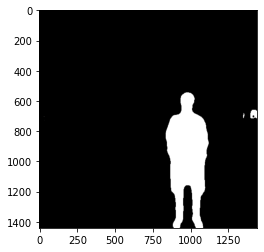

In [11]:
# seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [12]:
# 색상 코드 결과물에 주목
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

3채널 가졌던 원본과는 다르게 채널 정보가 사라졌음.
물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 됨.

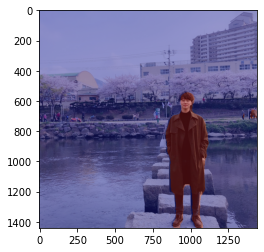

In [13]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기(blur 처리)

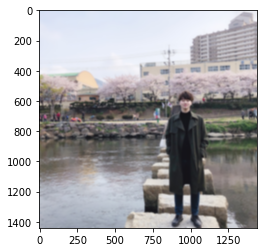

In [14]:
# (13,13)은 blurring kernel size를 뜻한다.

img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

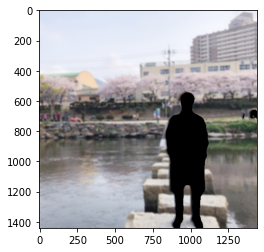

In [15]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 이미지 합성

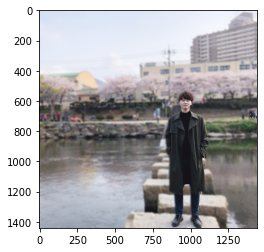

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용함.
np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했음.

### 문제점 :
- segmentation기법을 적용하였으나 원본 사진에 원거리에 있는 사람들이 부분적으로 라벨링 됨을 확인함

- 객체의 크기가 상대적으로 작으면 분할 성능이 저조해지는 문제점이 있어보임.
- 피사계심도를 이용한 아웃포커싱효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation)함.따라서 이를 모방한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기 어려움


## 2. 사람 2명이상인 사진 불러오기

## Instance segmentation

사람을 각각 인식하기 위해 PointRend Instance Segmentation모델을 사용함

- Instance segmentation : 사람 개개인별로 다른 라벨을 가지게 함. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하게 도움 줌.

In [17]:
!pip3 install pycocotools

     |████████████████████████████████| 106 kB 6.4 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp39-cp39-linux_x86_64.whl size=103779 sha256=a0837c142d95602eed71056080ed4d38766a5e4c3ca185610a1ffcbf11b687a9
  Stored in directory: /aiffel/.cache/pip/wheels/7e/b0/8e/f2c3593944ead79f5146d057d1310ee6d7b60d30b826779846
Successfully built pycocotools


In [18]:
!pip3 install pixellib

In [19]:
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

In [20]:
model_file = os.path.join(model_dir, 'pointrend_resnet101.pkl')
img1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img2.jpg'  
img1_orig = cv2.imread(img1_path)

ins = instanceSegmentation()
ins.load_model(model_file, network_backbone="resnet101")
results1, output1 = ins.segmentImage(img1_path, extract_from_box = True, # 박스는 필요없으므로 삭제
                                    extract_segmented_objects=True, save_extracted_objects=True)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/opt/conda/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


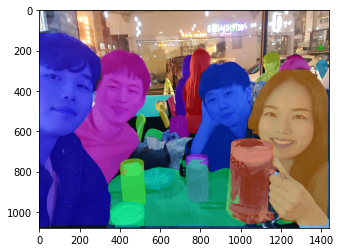

{'boxes': array([[ 715,  257, 1055,  841],
        [ 166,  195,  555,  885],
        [   1,  114,  364, 1080],
        [ 929,  631, 1203, 1059],
        [1025,  293, 1435, 1071],
        [ 398,  735,  533,  965],
        [ 725,  708,  845,  953],
        [ 520,  778,  679,  892],
        [1063,  208, 1203,  366],
        [ 351,  947,  524, 1077],
        [ 703,  189,  858,  612],
        [ 478,  514,  528,  658],
        [ 581,  455,  651,  586],
        [1192,  224, 1348,  308],
        [ 273,  698, 1259, 1069],
        [ 669,  222,  761,  533],
        [ 636,  424,  683,  528],
        [ 471,  419,  649,  528],
        [1383,  169, 1415,  198],
        [1369,  244, 1434,  346],
        [ 641,  517,  746,  631],
        [ 520,  586,  621,  659]]),
 'class_ids': array([ 0,  0,  0, 41,  0, 41, 41, 45,  0, 41,  0, 56, 56,  0, 60,  0, 56,
        56,  0,  0, 26, 56]),
 'class_names': ['person',
  'person',
  'person',
  'cup',
  'person',
  'cup',
  'cup',
  'bowl',
  'person',
  'cup',
 

In [21]:
plt.imshow(output1)
plt.show()
results1

### 사람을 개별로 인식할 수 있도록 변경

- target_classes를 설정

In [22]:
# 저장할 파일 이름 결정
img1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img2.jpg'  
img1_orig = cv2.imread(img1_path)

ins = instanceSegmentation()
ins.load_model(model_file, network_backbone="resnet101")
target_classes = ins.select_target_classes(person = True)
results1, output1 = ins.segmentImage(img1_path, segment_target_classes = target_classes, extract_from_box = True, 
                                    extract_segmented_objects=True, save_extracted_objects=True)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


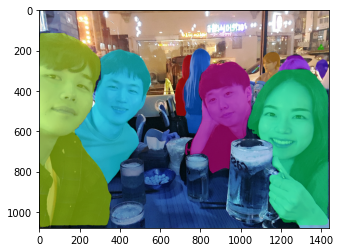

{'boxes': array([[ 715,  257, 1055,  841],
        [ 166,  195,  555,  885],
        [   1,  114,  364, 1080],
        [1025,  293, 1435, 1071],
        [1063,  208, 1203,  366],
        [ 703,  189,  858,  612],
        [1192,  224, 1348,  308],
        [ 669,  222,  761,  533],
        [1383,  169, 1415,  198],
        [1369,  244, 1434,  346]]),
 'class_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'class_names': ['person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person'],
 'object_counts': Counter({'person': 10}),
 'scores': array([99, 99, 99, 99, 98, 96, 87, 82, 62, 62]),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, F

In [23]:
plt.imshow(output1)
plt.show()
results1

class_ids를 보면 person으로 인식한 객체가 10개인 것을 확인 할 수 있다.
scores는 사람으로 인식된 것들을 점수로 나타낸 건데 사람이 앞에 가까울 수록 더 인식하므로 점수도 높게 나왔고, 애매 한부분들은 점수가 낮게 나온것을 확인할 수 있다.
masks에 보면 false 앞에 [[[는 3차원임을 의미함. 사람으로 인식된 10개의 개층 즉, 10개의 겹으로 된 이미지들이 3차원으로 형태를 이루고 있으며, 사람이 아닌 것들은 false로 처리되어있으므로, 사람인 부분 true 부분을 쉽게 파악하기 위해서는 1차원 형태로 바꾸는 것이 좋음

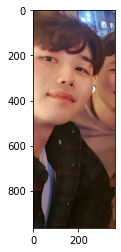

In [24]:
men = results1["extracted_objects"][2]
plt.imshow(cv2.cvtColor(men, cv2.COLOR_BGR2RGB))
plt.show()

#특정 사람이 어떤 라벨에 배정되어있는지는 랜덤으로 입력하면서 치는게 좋다함.
# 어차피 위에서 사람을 10개로 인식했으므로 0~10까지 쳐보면 될것 같음.

In [25]:
print(results1['masks'].shape)
print(results1['masks'].ndim)

(1080, 1440, 10)
3


In [26]:
men = results1['masks'][:,:,2]

In [27]:
men = np.reshape(men,(1080,1440,1, -1))

# 1차원 바꿔줌.

(1080, 1440, 1)


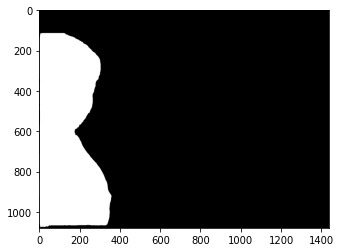

In [28]:
seg_map1 = np.all(men==True, axis=-1)

print(seg_map1.shape)
plt.imshow(seg_map1, cmap='gray')
plt.show()

In [29]:
men2 = results1['masks'][:,:,1]

In [30]:
men2 = np.reshape(men2,(1080,1440,1,-1))

(1080, 1440, 1)


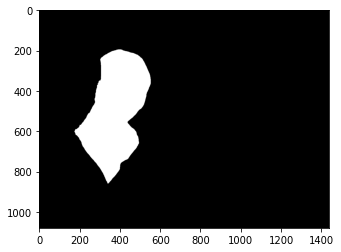

In [31]:
seg_map2 = np.all(men2==True, axis=-1)

print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

(1080, 1440, 1)


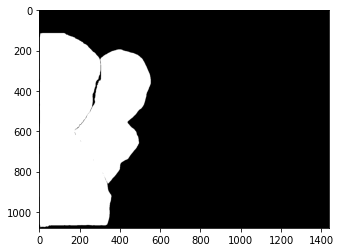

In [32]:
seg_map = np.bitwise_or(seg_map1, seg_map2)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

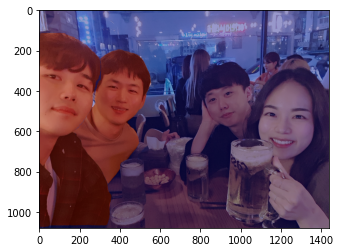

In [33]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img1_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img1_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask1 = cv2.applyColorMap(img1_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

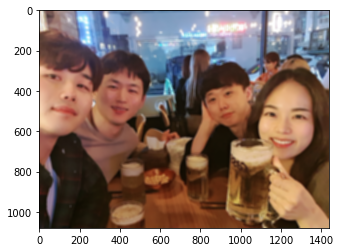

In [34]:
# (13,13)은 blurring kernel size를 뜻한다.

img1_orig_blur = cv2.blur(img1_orig, (13,13))  
plt.imshow(cv2.cvtColor(img1_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

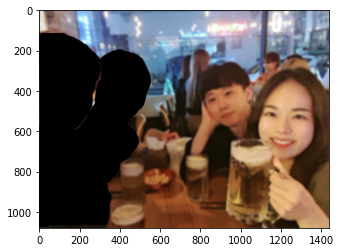

In [35]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img1_mask_color = cv2.cvtColor(img1_mask, cv2.COLOR_GRAY2BGR)
img1_bg_mask = cv2.bitwise_not(img1_mask_color)
img1_bg_blur = cv2.bitwise_and(img1_orig_blur, img1_bg_mask)
plt.imshow(cv2.cvtColor(img1_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

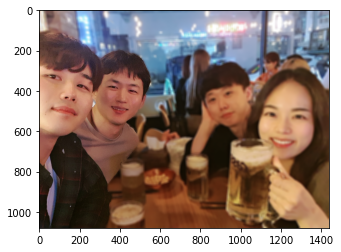

In [36]:
img1_concat = np.where(img1_mask_color==255, img1_orig, img1_bg_blur)
plt.imshow(cv2.cvtColor(img1_concat, cv2.COLOR_BGR2RGB))
plt.show()

모델(PointRend Instance Segmentation)을 바꿈으로써 원하는 사람만 남기고 blur처리를 할 수 있었음.

## 3. 색깔이 비슷한 고양이, 강아지 사진

### 이미지 불러오기

In [60]:
# 저장할 파일 이름 결정
img2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.png'  
img2_orig = cv2.imread(img2_path)

ins = instanceSegmentation()
ins.load_model(model_file, network_backbone="resnet101")
results2, output2 = ins.segmentImage(img2_path, extract_from_box = True, 
                                    extract_segmented_objects=True, save_extracted_objects=True)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [61]:
segvalues2, output2 = model.segmentAsPascalvoc(img2_path)

In [62]:
segvalues2

{'class_ids': array([ 0,  8, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

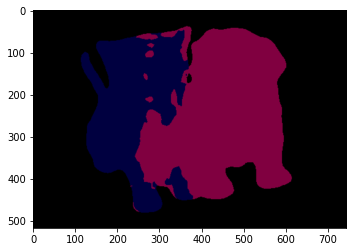

{'boxes': array([[111,  42, 392, 477],
        [329,  46, 614, 447],
        [320,  37, 608, 454],
        [  8,   0, 745, 491]]),
 'class_ids': array([15, 16, 15, 57]),
 'class_names': ['cat', 'dog', 'cat', 'couch'],
 'object_counts': Counter({'cat': 2, 'dog': 1, 'couch': 1}),
 'scores': tensor([99, 95, 85, 62]),
 'masks': array([[[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         ...,
         [False, False, False,  True],
         [False, False, False,  True],
         [False, False, False, False]],
 
        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         ...,
         [False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True]],
 
        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         ...,
         [False, False, False,  True],
   

In [63]:
plt.imshow(output2)
plt.show()
results2

In [64]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
dog


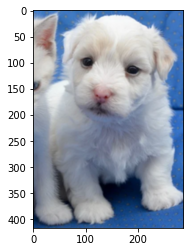

In [65]:
dog = results2["extracted_objects"][2]
plt.imshow(cv2.cvtColor(dog, cv2.COLOR_BGR2RGB))
plt.show()

In [66]:
print(results2['masks'].shape)
print(results2['masks'].ndim)

(517, 745, 4)
3


In [67]:
dog = results2['masks'][:,:,2]

In [68]:
dog = np.reshape(dog,(517,745,1,-1))

(517, 745, 1)


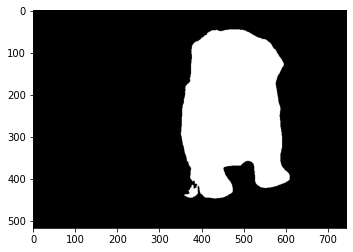

In [69]:
seg_map2 = np.all(dog==True, axis=-1)

print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

In [70]:
cat = results2['masks'][:,:,0]

In [71]:
cat = np.reshape(cat,(517,745,1,-1))

(517, 745, 1)


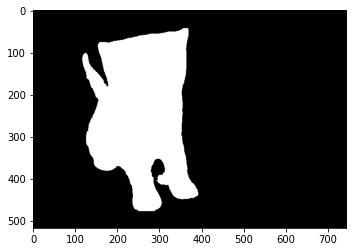

In [72]:
seg_map3 = np.all(cat==True, axis=-1)

print(seg_map3.shape)
plt.imshow(seg_map3, cmap='gray')
plt.show()

(517, 745, 1)


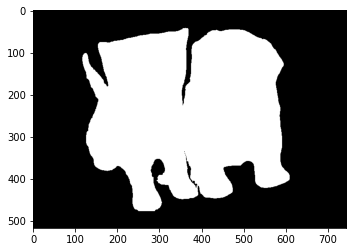

In [73]:
seg_map = np.bitwise_or(seg_map2, seg_map3)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [74]:
img_show.shape

(1080, 1440, 3)

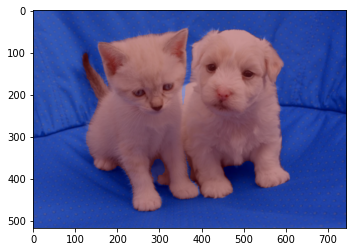

In [78]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img2_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img2_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask2 = cv2.applyColorMap(img2_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경흐리게 하기

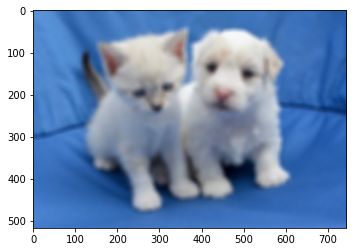

In [79]:
img_orig_blur = cv2.blur(img2_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### Segmentation으로 배경만 추출하기

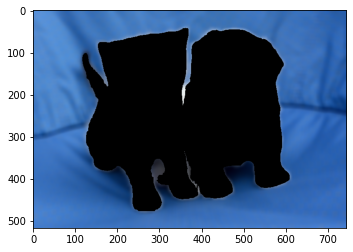

In [82]:
img_mask_color = cv2.cvtColor(img2_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경영상과 합치기

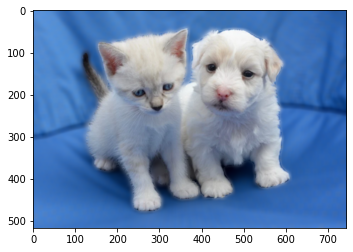

In [83]:
img_concat = np.where(img_mask_color==255, img2_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 초기 Semantic segmentation 문제점 :
- 색깔이 비슷한 강아지와 고양이를 두었을 때 각 개체에 대해 구별은 하나 겹치는 부분 때문인지 완벽한 라벨링이 이루어지지 않아보임.
- 처음에, 세번째 사진에서 고양이가 새를 물고 있는 사진을 하였는데 새의 색깔이 분명해도 새의 모양이 가로로 누워있어서 그런지 인식을 하지못함. 때문에 포기하고 다른 이미지를 가져옴.
- blur경계 부분이 부자연스러운 점 ->  경계 부분이 부드러워질 수 있도록 GaussianBlur를 사용할려했으나 model을 instance segmentation으로 바꿔 준 것만으로 충분한 라벨 효과를 볼 수 있었음.

## 4. 배경전환 크로마키사진

In [84]:
import pixellib
from pixellib.tune_bg import alter_bg

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'xception_pascalvoc.pb')


(1440, 1440, 3)


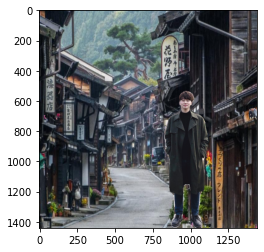

In [85]:
import pixellib
from pixellib.tune_bg import alter_bg

b_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bene.png'  
f_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/oh.png'
n_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'

change_bg = alter_bg(model_type = "pb")
change_bg.load_pascalvoc_model(model_file)
change_bg.change_bg_img(f_img_path, b_img_path, output_image_name=n_img_path + "new_img.png")

n_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/new_img.png' 
n_img_orig = cv2.imread(n_img_path)

print(n_img_orig.shape)
plt.imshow(cv2.cvtColor(n_img_orig, cv2.COLOR_BGR2RGB))
plt.show()


## 코드 에러 해결

- Error: OpenCV(3.4.2) error: (-209:Sizes of input arguments do not match) The operation is neither ‘array op array’ (where arrays have the same size and the same number of channels), nor ‘array op scalar’, nor ‘scalar op array’ in function ‘cv::arithm_op’

해결방안 : img_show = cv2.addWeighted(img_show, 0.6, color_mask2, 0.4, 0.0)에서 사이즈를 확인해봤을 때 img_show와 color_mask의 사이즈가 다름을 확인하고 사이즈를 맞춰줄려 했음. 하지만 결론적으로 경로에서 다른 이미지를 저장하는 실수였음. 이에 올바른 경로지정으로 문제해결함.

## 참고

https://openaccess.thecvf.com/content_CVPR_2020/papers/Kirillov_PointRend_Image_Segmentation_As_Rendering_CVPR_2020_paper.pdf

Deep Lab V3+ : https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

https://towardsdatascience.com/review-deeplabv3-atrous-convolution-semantic-segmentation-6d818bfd1d74

https://github.com/ayoolaolafenwa/PixelLib/blob/master/Tutorials/change_image_bg.md